In [97]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [98]:
def format_quarters(x, pos):
    date = mdates.num2date(x)  # Convert matplotlib date to datetime
    quarter = (date.month - 1) // 3 + 1  # Calculate the quarter
    if quarter == 1:  # Show year only for Q1
        return f"{date.year}-Q{quarter}"
    else:  # Show only the quarter for Q2, Q3, Q4
        return f"Q{quarter}"

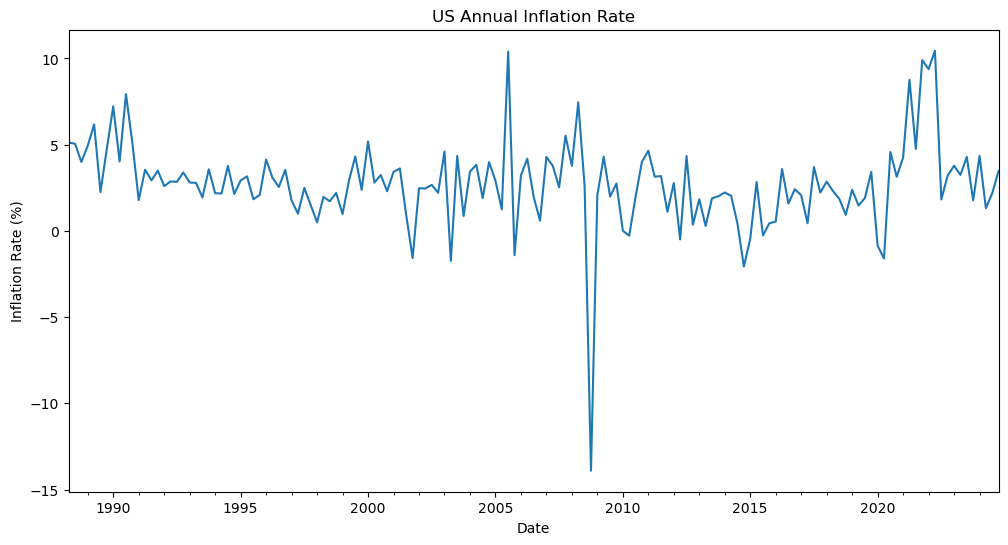

In [99]:
start_date = datetime.datetime(1988, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

# Download US CPI data from FRED using the symbol 'CPIAUCSL'
df_cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
df_cpi.dropna(inplace=True)

# Compute the annual inflation rate
df_cpi_quarterly = df_cpi.resample('QE').last()
df_cpi_quarterly['Annual Inflation Rate'] = 400 * np.log(
    df_cpi_quarterly['CPIAUCSL'] / df_cpi_quarterly['CPIAUCSL'].shift(1)
)
df_inflation = df_cpi_quarterly.dropna()

# Plot the annual inflation rate series
df_inflation['Annual Inflation Rate'].plot(title='US Annual Inflation Rate', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.show()

In [100]:
df_inflation

,CPIAUCSL,Annual Inflation Rate
DATE,,
1988-06-30,118.000,5.117341
1988-09-30,119.500,5.052699
1988-12-31,120.700,3.996703
1989-03-31,122.200,4.940367
1989-06-30,124.100,6.171458
...,...,...
2023-12-31,308.735,1.767223
2024-03-31,312.107,4.345110
2024-06-30,313.131,1.310222


In [101]:
# Extract the Annual Inflation Rate series
inflation_rate_series = df_inflation['Annual Inflation Rate']

# Perform the ADF test
adf_result = adfuller(inflation_rate_series)

# Display the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print("Augmented Dickey-Fuller Test Results:")
print(adf_output)



Augmented Dickey-Fuller Test Results:
Test Statistic                -9.829081e+00
p-value                        5.094083e-17
# of Lags Used                 0.000000e+00
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64


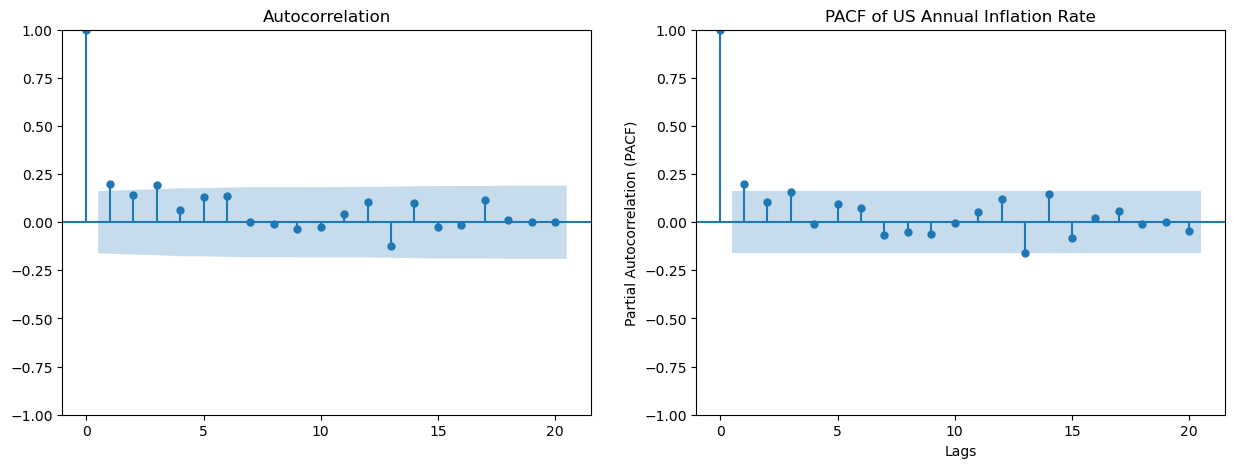

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF for the annual inflation rate
plot_acf(inflation_rate_series, lags=20, ax=axes[0])
# Plot the PACF for the annual inflation rate
plot_pacf(inflation_rate_series, lags=20, ax=axes[1])
plt.title("PACF of US Annual Inflation Rate")
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation (PACF)')
plt.show()


In [103]:
# Fit an AR(1) model
model_ar1 = AutoReg(df_inflation['Annual Inflation Rate'], lags=1).fit()
print("AR(1) Model Summary:")
print(model_ar1.summary())

# Choose the lag order based on the PACF plot
p = 6

# Fit an AR(p) model
model_arp = AutoReg(df_inflation['Annual Inflation Rate'], lags=p).fit()
print(f"\nAR({p}) Model Summary:")
print(model_arp.summary())

AR(1) Model Summary:
                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -340.591
Method:                  Conditional MLE   S.D. of innovations              2.494
Date:                   Thu, 03 Apr 2025   AIC                            687.182
Time:                           17:54:59   BIC                            696.133
Sample:                       09-30-1988   HQIC                           690.819
                            - 12-31-2024                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.1687      0.302      7.185      0.000       1.577       2.760
Annual Inflation Rate.L1     0.1997      0.0

In [104]:
def calculate_AR_model(df_inflation, lags):

    # Extract the 'Annual Inflation Rate' column
    inflation_rates = df_inflation['Annual Inflation Rate']

    # Fit the AR model
    model = AutoReg(inflation_rates, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Get the AR coefficients (excluding the intercept term)
    ar_coef = model_fit.params[1:]

    # Print AR coefficients
    print("\nAR Coefficients:")
    print(ar_coef)

    # Get the residuals
    residuals = model_fit.resid

    # Plot the ACF of residuals
    plt.figure(figsize=(12, 6))
    plot_acf(residuals, lags=12, alpha=0.05)
    plt.title("Autocorrelation Function (ACF) of Residuals")
    plt.show()

    # Perform the Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results for Residuals:")
    print(lb_test)

    # Return results
    return model_fit, ar_coef, lb_test, residuals


                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -340.591
Method:                  Conditional MLE   S.D. of innovations              2.494
Date:                   Thu, 03 Apr 2025   AIC                            687.182
Time:                           17:54:59   BIC                            696.133
Sample:                       09-30-1988   HQIC                           690.819
                            - 12-31-2024                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.1687      0.302      7.185      0.000       1.577       2.760
Annual Inflation Rate.L1     0.1997      0.081      2.469      0.

<Figure size 1200x600 with 0 Axes>

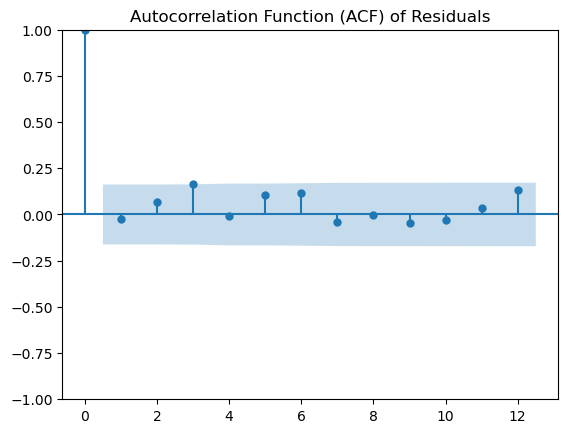

Ljung-Box Test Results for Residuals:
     lb_stat  lb_pvalue
10  9.246308   0.508899


In [105]:
model_fit, ar_coef, lb_test, residuals = calculate_AR_model(df_inflation, lags=1)

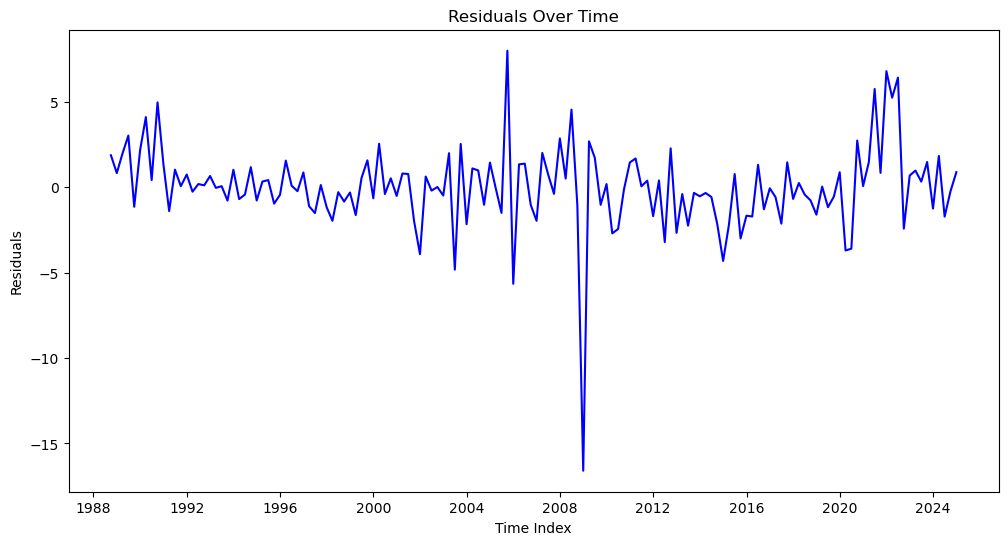

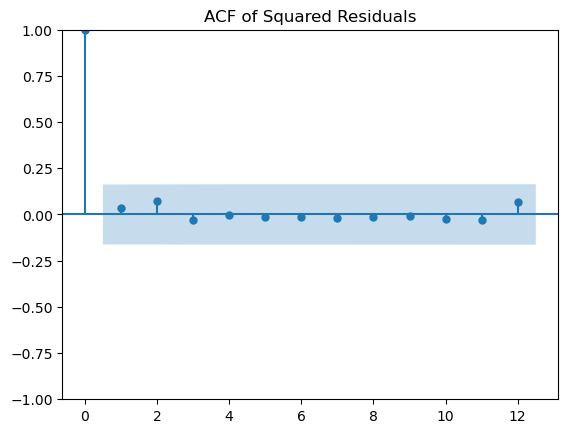

ARCH Test Results:
LM Statistic      1.146296
p-value           0.999679
F-statistic       0.106254
F-test p-value    0.999743
dtype: float64


In [106]:
# Plot the residuals to visually inspect for volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(residuals ** 2, lags=12, alpha = 0.05)
plt.title('ACF of Squared Residuals')
plt.show()

# Perform the ARCH-LM Test
arch_test = het_arch(residuals)
arch_test_results = pd.Series(arch_test, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results)


In [107]:
results = []
for i in range(1, 10):  # AR models from lag 1 to 9

    model = AutoReg(inflation_rate_series, lags=i)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    results.append([i, aic, bic])
    print(f"AR({i}): AIC={aic:.2f}, BIC={bic:.2f}")

# Find the best models based on AIC and BIC
results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC'])
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]  # Find row with minimum AIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]  # Find row with minimum BIC


print(f"\nBest Model (AIC): Lag {int(best_aic_model['Lag'])}, AIC={best_aic_model['AIC']:.2f}, BIC={best_aic_model['BIC']:.2f}")
print(f"Best Model (BIC): Lag {int(best_bic_model['Lag'])}, AIC={best_bic_model['AIC']:.2f}, BIC={best_bic_model['BIC']:.2f}")

AR(1): AIC=687.18, BIC=696.13
AR(2): AIC=683.34, BIC=695.24
AR(3): AIC=677.94, BIC=692.79
AR(4): AIC=675.92, BIC=693.69
AR(5): AIC=671.66, BIC=692.35
AR(6): AIC=668.90, BIC=692.49
AR(7): AIC=666.39, BIC=692.87
AR(8): AIC=662.04, BIC=691.38
AR(9): AIC=659.90, BIC=692.10

Best Model (AIC): Lag 9, AIC=659.90, BIC=692.10
Best Model (BIC): Lag 8, AIC=662.04, BIC=691.38


In [108]:
# Define Train and Test Sets Using Boolean Indexing
train_data = df_inflation.loc[df_inflation.index < '2022-06-01']
test_data = df_inflation.loc[df_inflation.index >= '2022-06-01']

In [109]:
# Fit an AR(1) model
model_ar1 = AutoReg(train_data['Annual Inflation Rate'], lags=1).fit()
print("\nAR(1) Model Summary:")
print(model_ar1.summary())

# # Fit an AR(3) model
# model_ar3 = AutoReg(train_data['Annual Inflation Rate'], lags=3).fit()
# print("\nAR(3) Model Summary:")
# print(model_ar3.summary())

# # Fit an AR(6) model
# model_ar6 = AutoReg(train_data['Annual Inflation Rate'], lags=6).fit()
# print("\nAR(6) Model Summary:")
# print(model_ar6.summary())

# Fit an AR(9) model
model_ar9 = AutoReg(train_data['Annual Inflation Rate'], lags=9).fit()
print("\nAR(9) Model Summary:")
print(model_ar9.summary())



AR(1) Model Summary:
                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  136
Model:                        AutoReg(1)   Log Likelihood                -315.600
Method:                  Conditional MLE   S.D. of innovations              2.506
Date:                   Thu, 03 Apr 2025   AIC                            637.199
Time:                           17:55:00   BIC                            645.915
Sample:                       09-30-1988   HQIC                           640.741
                            - 03-31-2022                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.1770      0.313      6.966      0.000       1.565       2.790
Annual Inflation Rate.L1     0.1769      0.

In [110]:
# Forecasting
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]

# Forecast using the AR(1) model
pred_ar1 = model_ar1.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Forecast using the AR(3) model
# pred_ar3 = model_ar3.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Forecast using the AR(6) model
# pred_ar6 = model_ar6.predict(start=forecast_start, end=forecast_end, dynamic=True)
pred_ar9 = model_ar9.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Calculate RMSE for each model
rmse_ar1 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar1))
# rmse_ar3 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar3))
# rmse_ar6 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar6))
rmse_ar9 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar9))

print("\nForecast Performance:")
print("AR(1) RMSE: {:.4f}".format(rmse_ar1))
# print("AR(3) RMSE: {:.4f}".format(rmse_ar3))
# print("AR(6) RMSE: {:.4f}".format(rmse_ar6))
print("AR(9) RMSE: {:.4f}".format(rmse_ar9))


Forecast Performance:
AR(1) RMSE: 2.2496
AR(9) RMSE: 2.3606


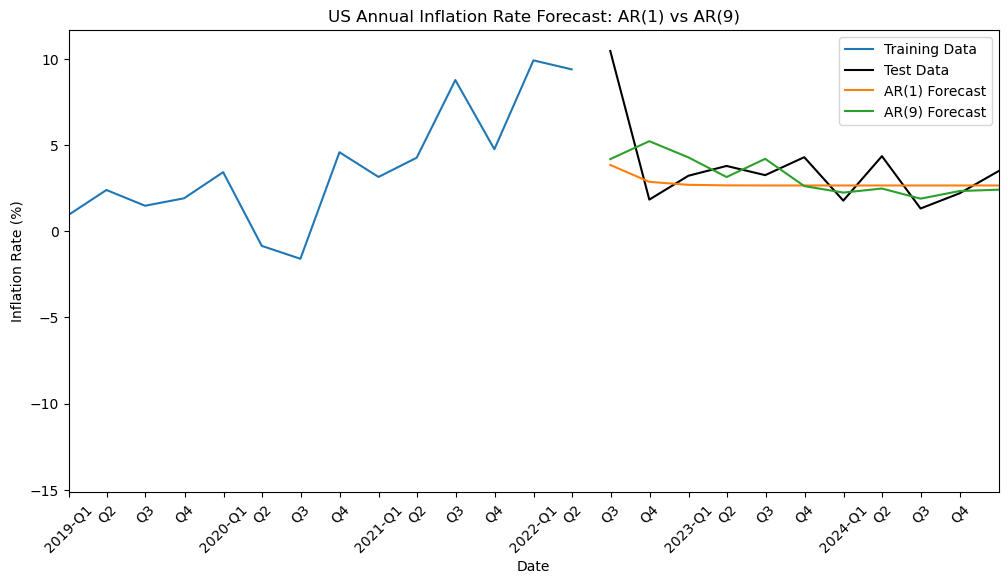

In [111]:
# Actual vs Forecast Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar1.index, pred_ar1, label='AR(1) Forecast')
plt.plot(pred_ar9.index, pred_ar9, label='AR(9) Forecast')
plt.title("US Annual Inflation Rate Forecast: AR(1) vs AR(9)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.xlim([datetime.datetime(2019, 1, 1), datetime.datetime(2024, 12, 31)])
# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=10, rotation=45)
plt.legend()
plt.show()

Exogenous variables

In [112]:
# Fit an ARDL model with exogenous variables
df_inflation_quarterly = df_inflation.resample('QE').last()
df_inflation_quarterly

,CPIAUCSL,Annual Inflation Rate
DATE,,
1988-06-30,118.000,5.117341
1988-09-30,119.500,5.052699
1988-12-31,120.700,3.996703
1989-03-31,122.200,4.940367
1989-06-30,124.100,6.171458
...,...,...
2023-12-31,308.735,1.767223
2024-03-31,312.107,4.345110
2024-06-30,313.131,1.310222


In [113]:
df_gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)
# Compute quarterly GDP change (log difference * 100)
df_gdp['Quarterly GDP Change'] = np.log(df_gdp['GDPC1']).diff() * 100
df_gdp.index = pd.to_datetime(df_gdp.index)
# Convert to quarterly period and then get the quarter-end timestamp
df_gdp.index = df_gdp.index.to_period('Q').to_timestamp('Q')
df_gdp.dropna(subset=['Quarterly GDP Change'], inplace=True)
df_gdp

,GDPC1,Quarterly GDP Change
DATE,,
1988-06-30,9490.594,1.305474
1988-09-30,9546.206,0.584260
1988-12-31,9673.405,1.323657
1989-03-31,9771.725,1.011264
1989-06-30,9846.293,0.760203
...,...,...
2023-12-31,22960.600,0.785579
2024-03-31,23053.545,0.403985
2024-06-30,23223.906,0.736263


In [114]:
df_interest = web.DataReader('GS10', 'fred', start_date, end_date)
df_interest_quarterly = df_interest.resample('QE').mean()
df_interest_quarterly.rename(columns={'GS10': 'Interest Rate Quarterly'}, inplace=True)
df_interest_quarterly

,Interest Rate Quarterly
DATE,
1988-03-31,8.416667
1988-06-30,8.910000
1988-09-30,9.100000
1988-12-31,8.956667
1989-03-31,9.206667
...,...
2023-12-31,4.440000
2024-03-31,4.160000
2024-06-30,4.443333


In [115]:
df_unemp = web.DataReader('UNRATE', 'fred', start_date, end_date)
df_unemp_quarterly = df_unemp.resample('QE').mean()
df_unemp_quarterly.rename(columns={'UNRATE': 'Unemployment Rate Quarterly'}, inplace=True)
df_unemp_quarterly

,Unemployment Rate Quarterly
DATE,
1988-03-31,5.700000
1988-06-30,5.466667
1988-09-30,5.466667
1988-12-31,5.333333
1989-03-31,5.200000
...,...
2023-12-31,3.800000
2024-03-31,3.833333
2024-06-30,4.000000


In [116]:
df_quarterly = pd.concat([
    df_inflation_quarterly['Annual Inflation Rate'],
    df_gdp['Quarterly GDP Change'],
    df_interest_quarterly['Interest Rate Quarterly'],
    df_unemp_quarterly['Unemployment Rate Quarterly']
], axis=1, join='inner')

df_quarterly.dropna(inplace=True)  # ensure no missing values remain
print("Merged Quarterly Data:")
df_quarterly

Merged Quarterly Data:


,Annual Inflation Rate,Quarterly GDP Change,Interest Rate Quarterly,Unemployment Rate Quarterly
DATE,,,,
1988-06-30,5.117341,1.305474,8.910000,5.466667
1988-09-30,5.052699,0.584260,9.100000,5.466667
1988-12-31,3.996703,1.323657,8.956667,5.333333
1989-03-31,4.940367,1.011264,9.206667,5.200000
1989-06-30,6.171458,0.760203,8.773333,5.233333
...,...,...,...,...
2023-12-31,1.767223,0.785579,4.440000,3.800000
2024-03-31,4.345110,0.403985,4.160000,3.833333
2024-06-30,1.310222,0.736263,4.443333,4.000000


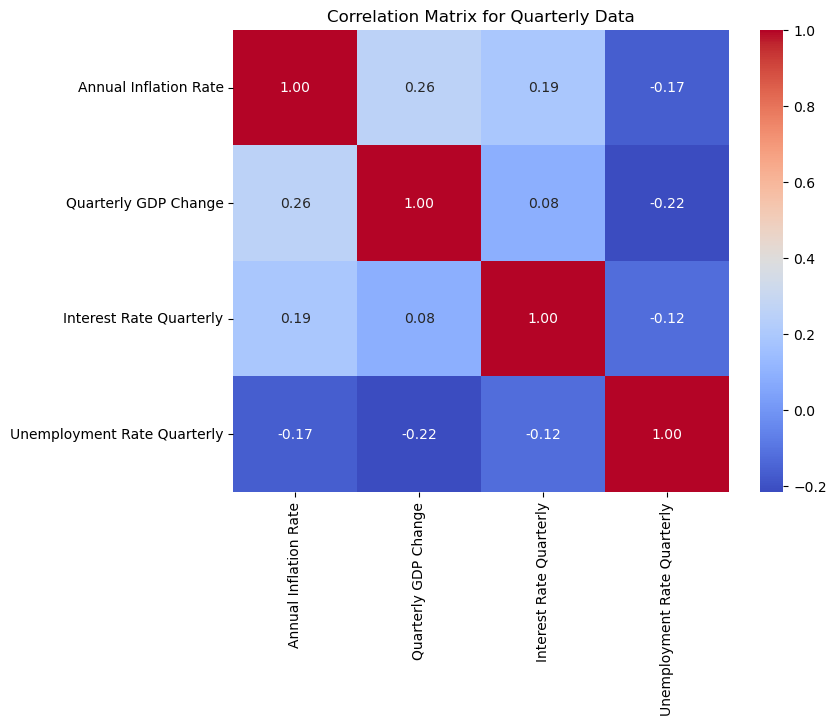

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df_quarterly.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

# Add title
plt.title("Correlation Matrix for Quarterly Data")

# Show the plot
plt.show()

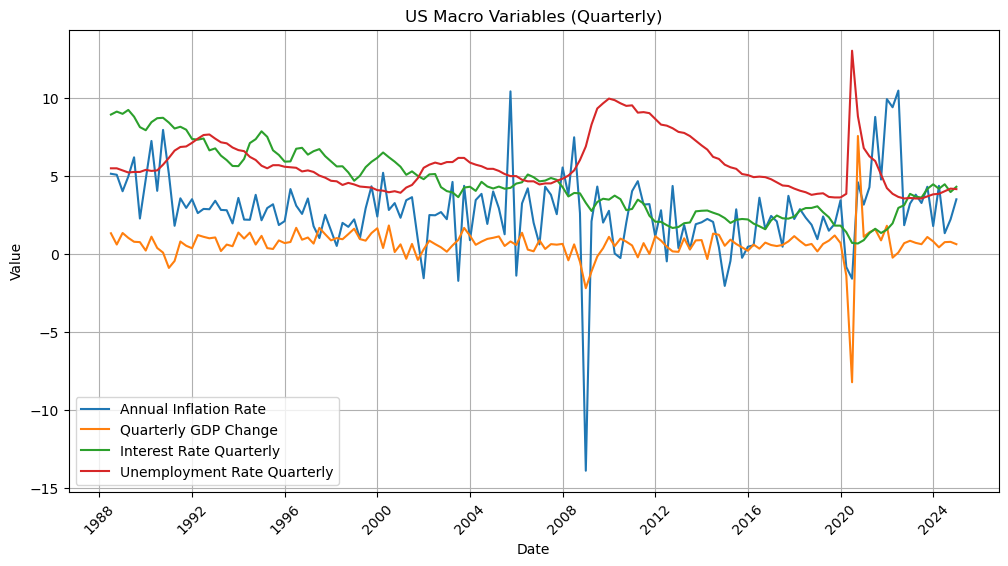

In [117]:
plt.figure(figsize=(12, 6))
for col in df_quarterly.columns:
    plt.plot(df_quarterly.index, df_quarterly[col], label=col)
plt.title('US Macro Variables (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [118]:
# Define exogenous variables using the correct column names from df_combined
exog = df_quarterly[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']].copy()

# Fit the ARDL model
model = ARDL(df_quarterly['Annual Inflation Rate'], lags=6, exog=exog, order=12, causal=True)
result = model.fit()

# Display the model summary
print(result.summary())

# Extract p-values and coefficients from the fitted model
pvalues = result.pvalues
coefficients = result.params

# Filter out coefficients with p-values < 0.05
significant_coefs = coefficients[pvalues < 0.05]

print("\nSignificant Coefficients with 95% confidence level (p-value < 0.05):")
print(significant_coefs)

                                ARDL Model Results                               
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:               ARDL(6, 12, 12, 12)   Log Likelihood                -297.696
Method:                  Conditional MLE   S.D. of innovations              1.998
Date:                   Thu, 03 Apr 2025   AIC                            683.391
Time:                           17:55:03   BIC                            813.137
Sample:                       06-30-1991   HQIC                           736.116
                            - 12-31-2024                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.8611      2.170      0.397      0.692      -3.446       5.168
Annual Inflation Rate.L1            0.0651  

Inflation is largely self-driven in the short run, with a strong effect from the immediate preceding quarter (L1).

There appears to be a cyclical or corrective dynamic around one year (L4) and beyond (L5).

Other macro variables are not showing strong short-run predictive power once past inflation is included—at least in this specific ARDL model

## Checking for AR lag with no significant ARCH effects and is stationary

In [119]:
max_lag = 12
results = []

for lag in range(1, max_lag + 1):
    model = AutoReg(inflation_rate_series, lags=lag, old_names=False).fit()
    resid = model.resid

    # Check stationarity: For inverse roots, all must be > 1
    stationary = all(np.abs(model.roots) > 1)

    # ARCH test: high p-value (> 0.05)
    arch_p = het_arch(resid)[1]

    # Ljung-Box test at lag 10: high p-value (> 0.05) indicates no autocorrelation
    lb_p = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]

    results.append({
        'lag': lag,
        'AIC': model.aic,
        'BIC': model.bic,
        'Stationary': stationary,
        'ARCH p': arch_p,
        'LB p': lb_p
    })

results_df = pd.DataFrame(results)
print("Candidate AR(p) Models:")
print(results_df)

# Filter models that are stationary and show no significant ARCH effects or autocorrelation effects
filtered_df = results_df[
    (results_df['Stationary']) &
    (results_df['ARCH p'] > 0.05) &
    (results_df['LB p'] > 0.05)
]

print("\nShortlisted Models (Stationary, no ARCH/autocorrelation effects):")
print(filtered_df)

# Choose the best model based on AIC and BIC.
if not filtered_df.empty:
    best_aic = filtered_df.loc[filtered_df['AIC'].idxmin()]
    best_bic = filtered_df.loc[filtered_df['BIC'].idxmin()]
    print(f"\nBest Model by AIC: AR({int(best_aic['lag'])}) with AIC={best_aic['AIC']:.2f} and BIC={best_aic['BIC']:.2f}")
    print(f"Best Model by BIC: AR({int(best_bic['lag'])}) with AIC={best_bic['AIC']:.2f} and BIC={best_bic['BIC']:.2f}")
else:
    print("\nNo AR(p) model from 1 to 12 passed all the diagnostic criteria.")


Candidate AR(p) Models:
    lag         AIC         BIC  Stationary    ARCH p      LB p
0     1  687.181693  696.132512        True  0.999679  0.508899
1     2  683.337587  695.244522        True  0.999650  0.716040
2     3  677.941606  692.790672        True  0.999807  0.900504
3     4  675.915864  693.692931        True  0.999779  0.919651
4     5  671.657390  692.348179        True  0.999762  0.975398
5     6  668.903378  692.493457        True  0.999596  0.984674
6     7  666.392740  692.867522        True  0.999739  0.994713
7     8  662.039458  691.384198        True  0.999622  0.998502
8     9  659.902732  692.102522        True  0.999547  0.999988
9    10  654.953337  689.993108        True  0.999530  0.999999
10   11  652.582582  690.447095        True  0.999839  1.000000
11   12  648.269641  688.943488        True  0.999657  1.000000

Shortlisted Models (Stationary, no ARCH/autocorrelation effects):
    lag         AIC         BIC  Stationary    ARCH p      LB p
0     1  687.

#### Using best lag 12

AR(12) Model Summary:
                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                       AutoReg(12)   Log Likelihood                -310.135
Method:                  Conditional MLE   S.D. of innovations              2.407
Date:                   Thu, 03 Apr 2025   AIC                            648.270
Time:                           18:35:43   BIC                            688.943
Sample:                       06-30-1991   HQIC                           664.798
                            - 12-31-2024                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.4979      0.556      2.693      0.007       0.408       2.588
Annual Inflation Rate.L1      0.1251    

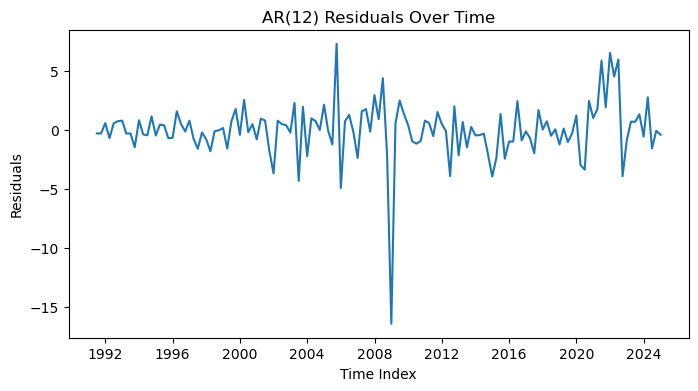

<Figure size 800x400 with 0 Axes>

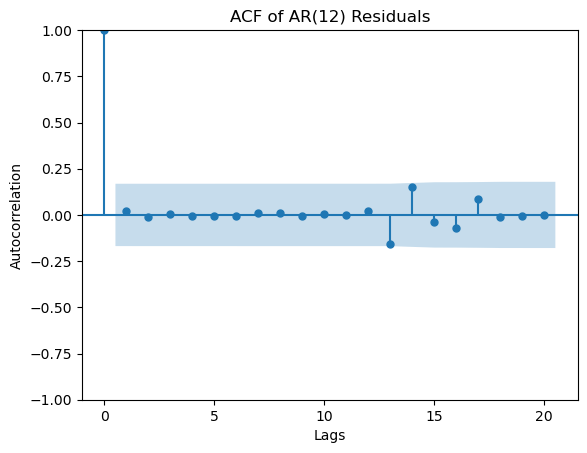

<Figure size 800x400 with 0 Axes>

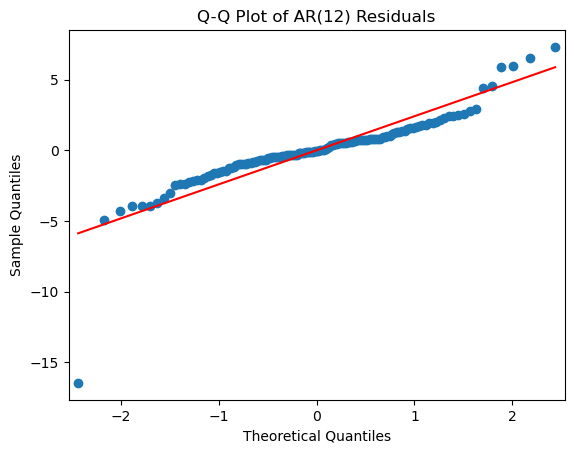

Ljung-Box Test Results for Residuals:
     lb_stat  lb_pvalue
20  9.763789   0.972256


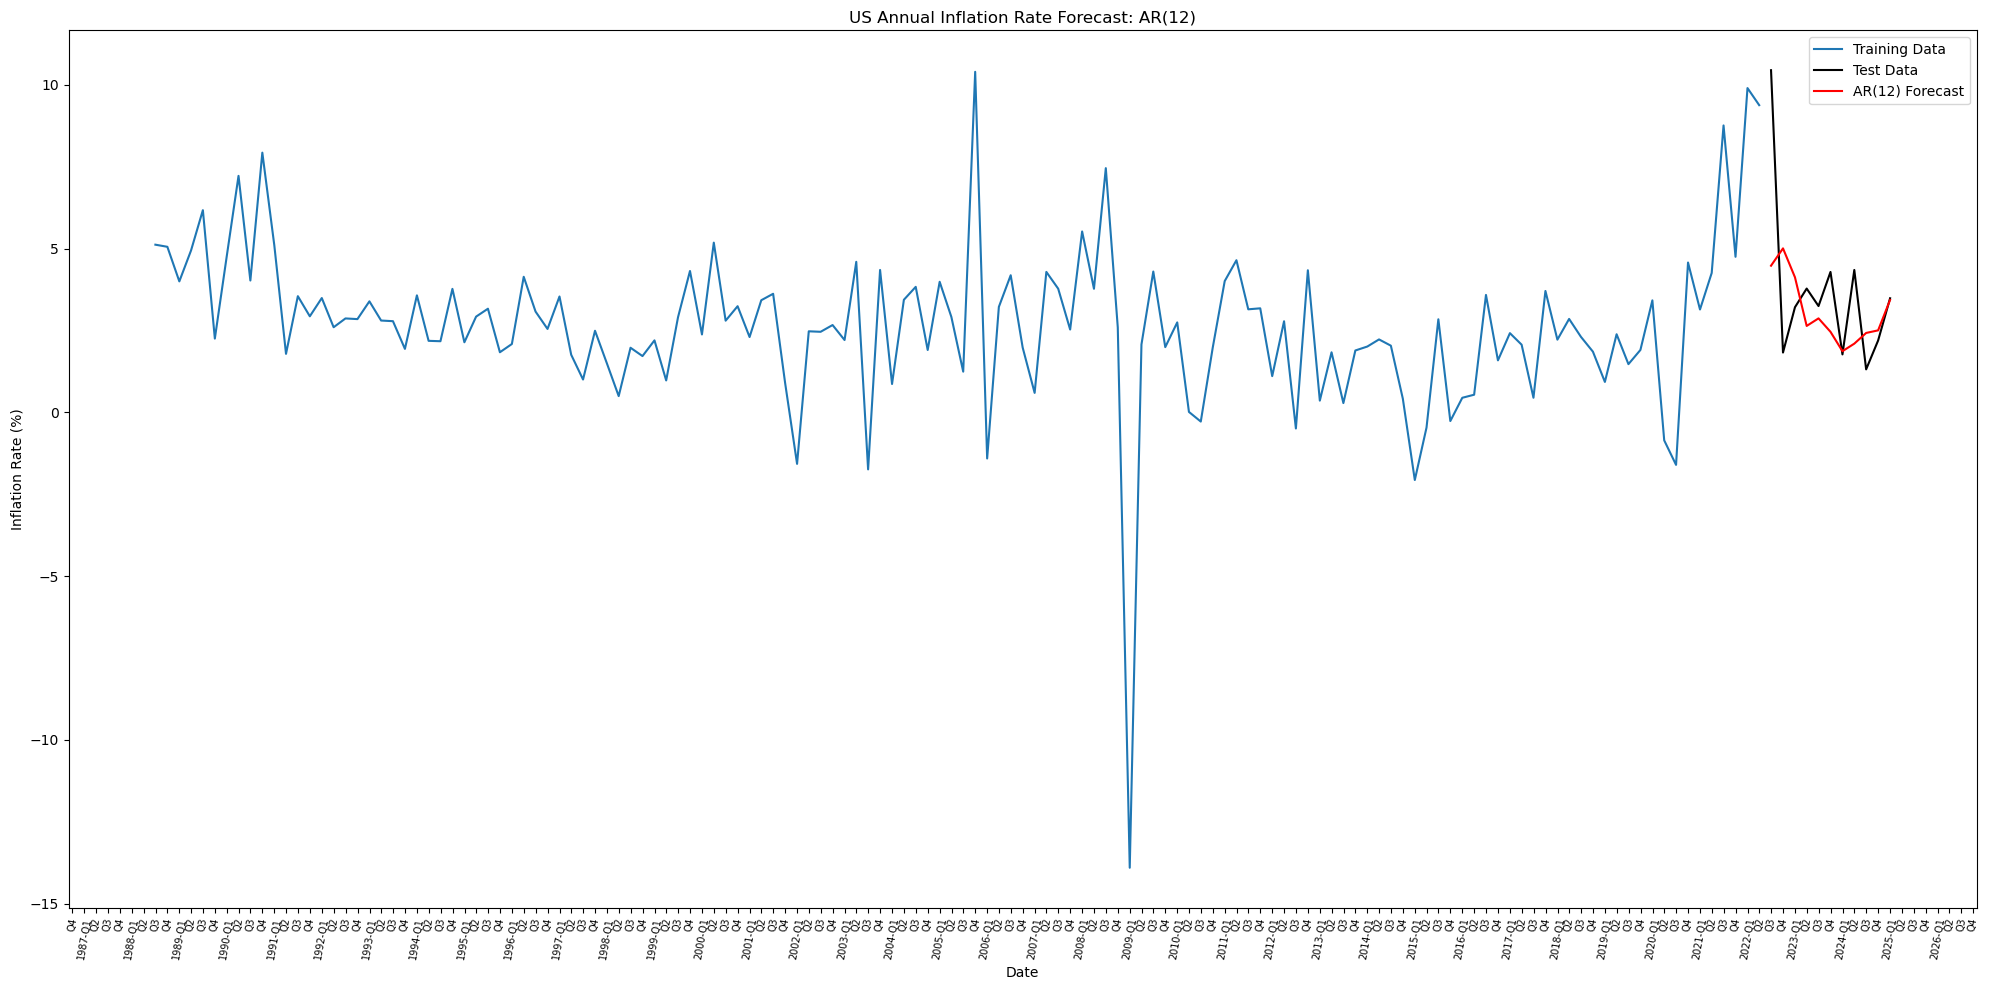

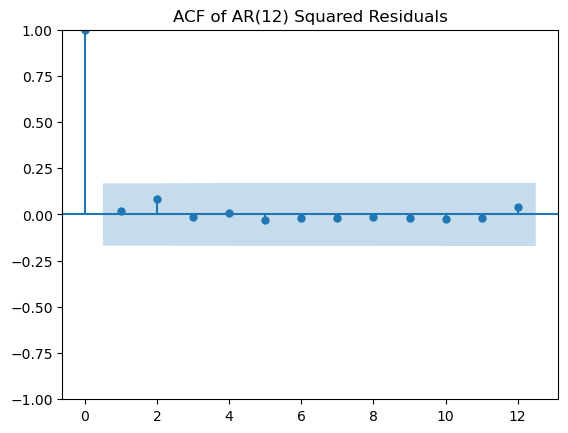

ARCH Test Results:
LM Statistic      1.163196
p-value           0.999657
F-statistic       0.107080
F-test p-value    0.999731
dtype: float64
AR(12) Forecast RMSE: 2.2916


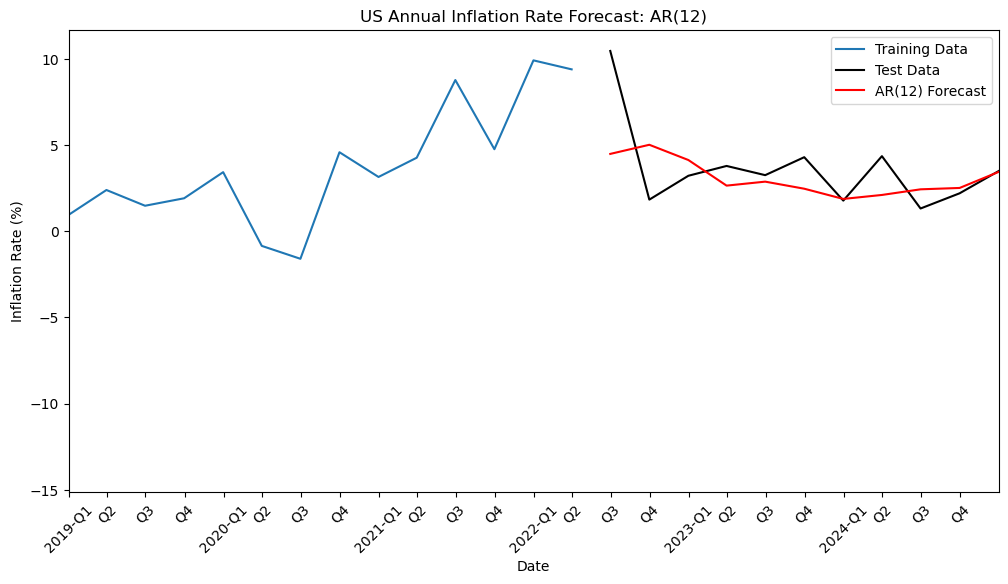

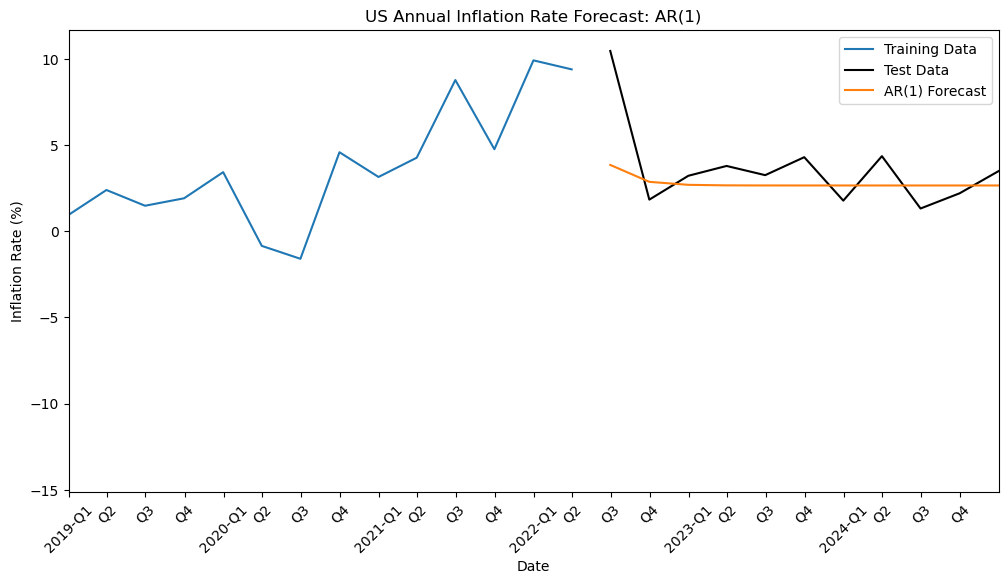

In [126]:
model_ar12 = AutoReg(inflation_rate_series, lags=12, old_names=False).fit()
print("AR(12) Model Summary:")
print(model_ar12.summary())

# Checking residuals
resid_ar12 = model_ar12.resid

# Plot residuals over time
plt.figure(figsize=(8, 4))
plt.plot(resid_ar12)
plt.title("AR(12) Residuals Over Time")
plt.xlabel("Time Index")
plt.ylabel("Residuals")
plt.show()

# Plot the ACF of residuals
plt.figure(figsize=(8, 4))
plot_acf(resid_ar12, lags=20, alpha=0.05)
plt.title("ACF of AR(12) Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

# Q-Q plot for residuals
plt.figure(figsize=(8, 4))
sm.qqplot(resid_ar12, line='s')
plt.title("Q-Q Plot of AR(12) Residuals")
plt.show()

# Perform the Ljung-Box test on residuals
lb_test = acorr_ljungbox(resid_ar12, lags=[20], return_df=True)
print("Ljung-Box Test Results for Residuals:")
print(lb_test)

# Forecasting
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]
pred_ar12 = model_ar12.predict(start=forecast_start, end=forecast_end, dynamic=True)

# Plot Actual vs. Forecast
plt.figure(figsize=(20, 10))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar12.index, pred_ar12, label='AR(12) Forecast', color='red')
plt.title("US Annual Inflation Rate Forecast: AR(12)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")

# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=7, rotation=80)

# Tighten the layout to prevent label overlap
plt.tight_layout()

plt.legend()
plt.show()

# Perform the LM test for squared residuals
ar12_squared_resid = resid_ar12 ** 2

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(ar12_squared_resid, lags=12, alpha = 0.05)
plt.title('ACF of AR(12) Squared Residuals')
plt.show()

arch_test_ar12 = het_arch(resid_ar12)
arch_test_results_ar12 = pd.Series(arch_test_ar12, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results_ar12)

# Calculate RMSE for AR(12) model
rmse_ar12 = np.sqrt(mean_squared_error(test_data['Annual Inflation Rate'], pred_ar12))
print("AR(12) Forecast RMSE: {:.4f}".format(rmse_ar12))

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar12.index, pred_ar12, label='AR(12) Forecast', color='red')
plt.title("US Annual Inflation Rate Forecast: AR(12)")
plt.xlabel("Date")
plt.xlim([datetime.datetime(2019, 1, 1), datetime.datetime(2024, 12, 31)])
plt.ylabel("Inflation Rate (%)")


# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=10, rotation=45)

plt.legend()
plt.show()

# Calculate RMSE for AR(1) model

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Annual Inflation Rate'], label='Test Data', color='black')
plt.plot(pred_ar1.index, pred_ar1, label='AR(1) Forecast')
plt.title("US Annual Inflation Rate Forecast: AR(1)")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.xlim([datetime.datetime(2019, 1, 1), datetime.datetime(2024, 12, 31)])

# Format x-axis to show year and all quarters
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_quarters))

# Set major ticks to every quarter
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # January, April, July, October

# Reduce font size and rotate x-axis labels
plt.xticks(fontsize=10, rotation=45)

plt.legend()
plt.show()

